In [26]:
import torch
from transformers import *
import json
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import defaultdict
from datetime import datetime

from sentence_transformers import SentenceTransformer, LoggingHandler

In [27]:
def untokenized_reader(filename, typ='original'):
    # return list of original / words / lemma / pos
    with open(filename) as f:
        data = json.load(f)
    res = []
    assert typ in ['original', 'words', 'lemma', 'pos'], 'typ should in [original, words, lemma, pos]'
    
    if typ == 'original':
        for j in data:
            res.append(j['headline'])
    if typ == 'words':
        for j in data:
            res.append(j['words'])
    if typ == 'lemma':
        for j in data:
            res.append(j['lemma'])
    if typ == 'pos':
        for j in data:
            res.append(j['pos'])    
    return res

def padding(tokenized):
    max_len = 0
    for i in tokenized:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])
    return padded

def df_label(target):
    num_cls = len(target)
    df = pd.DataFrame(data=np.array(target[0]))
    df[len(df.columns)] = 0
    for label in range(1, num_cls):
        df1 = pd.DataFrame(data=np.array(target[label]))
        df1[len(df1.columns)] = label
        df = pd.concat([df, df1])
        
    return df
        
        

In [28]:
def transformer_embedding(target:list, choice:int):
    MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased'),
              (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
              (GPT2Model,       GPT2Tokenizer,       'gpt2'),
              (CTRLModel,       CTRLTokenizer,       'ctrl'),
              (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
              (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
              (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
              (DistilBertModel, DistilBertTokenizer, 'distilbert-base-cased'),
              (RobertaModel,    RobertaTokenizer,    'roberta-base'),
              (XLMRobertaModel, XLMRobertaTokenizer, 'xlm-roberta-base'),
             ]
    
    print("Processing %d sentence"%len(target))
    model_class, tokenizer_class, pretrained_weights = MODELS[choice]
    
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    tokenized = [tokenizer.encode(x, add_special_tokens=True) for x in target]
    
    padded = padding(tokenized)
    input_ids = torch.tensor(np.array(padded))
    
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        #Slice the output for the first position for all the sequences, take all hidden unit outputs
        embed = last_hidden_states[0][:,0,:].numpy()
    return embed

In [29]:
def sbert_embedding(model, sentences):
    sentence_embeddings = model.encode(sentences)
    return sentence_embeddings


In [106]:
# df_fox = pd.read_json('filtered_fox_headlines.json')
# df_fox['source'] = 'fox'
# df_msnbc = pd.read_json('filtered_msnbc_headlines.json')
# df_msnbc['source'] = 'msnbc'

# df = pd.concat([df_msnbc, df_fox])

df = pd.read_json('headlines_lda_mallet.json')
# source=df['source'].unique().tolist()
# df_fox = df.loc[df.source=='fox']
# df_msnbc = df.loc[df.source=='msnbc']

In [107]:
# word level bert
# emb_fox = transformer_embedding(data_fox, 0)
# emb_msnbc = transformer_embedding(data_msnbc, 0)

# sen-bert
model = SentenceTransformer('bert-large-nli-stsb-mean-tokens')
# emb_fox = sbert_embedding(model, df_fox['headline'].tolist())
# emb_msnbc = sbert_embedding(model, df_msnbc['headline'].tolist())
emb_all = sbert_embedding(model, df['headline'].tolist())


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
%matplotlib inline


In [109]:
# df_fox = df_label([emb_fox])
# df_msnbc = df_label([emb_msnbc])

In [110]:
# df_fox = df_fox.iloc[:, :-1]
# df_msnbc = df_fox.iloc[:, :-1]

In [111]:
# from sklearn.manifold import TSNE
# tsne = TSNE(random_state=1, n_iter=300, metric="cosine", perplexity=100)
# embs_fox = tsne.fit_transform(df_fox)
# embs_msnbc = tsne.fit_transform(df_msnbc)

In [112]:
# df_tsne_fox = pd.DataFrame({'x' : [], 'y' : []})
# df_tsne_fox['x'] = embs_fox[:, 0]
# df_tsne_fox['y'] = embs_fox[:, 1]

# df_tsne_msnbc = pd.DataFrame({'x' : [], 'y' : []})
# df_tsne_msnbc['x'] = embs_msnbc[:, 0]
# df_tsne_msnbc['y'] = embs_msnbc[:, 1]

In [113]:
# FS = (10, 8)
# fig, ax = plt.subplots(figsize=FS)
# ax.scatter(df_tsne_fox.x, df_tsne_fox.y, alpha=.2, c='b')
# ax.scatter(df_tsne_msnbc.x, df_tsne_msnbc.y, alpha=.2, c='r')

# plt.savefig("tsne.png")

In [114]:
import time                   # To time processes
import warnings               # To suppress warnings

import numpy as np            # Data manipulation
import pandas as pd           # Dataframe manipulatio 
import matplotlib.pyplot as plt                   # For graphics

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import os                     # For os related operations
import sys                    # For data size

In [115]:
def doKmeans(X, nclust=5):
    model = KMeans(nclust, max_iter=200)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [116]:
# df_kmean = df_label([emb_fox, emb_msnbc])
df_kmean = df_label([emb_all])
clust_labels, cent = doKmeans(df_kmean.iloc[:,:-1], 7)
print(len(clust_labels))
kmeans = pd.DataFrame(clust_labels)
df.insert((df.shape[1]),'kmeans',kmeans)
df.to_json("kmeans.json")

df.head()


3241


,index,date,entities,headline,lemmas,pos,sentiment_polarity,sentiment_subjectivity,source,words,topic,topic_contribution,kmeans
0,0,2020-01-30,"[{'text': 'Trump', 'type': 'PERSON', 'start_ch...",Trump cabinet secretary looks for silver linin...,"[Trump, cabinet, secretary, look, for, silver,...","[PROPN, NOUN, NOUN, VERB, ADP, NOUN, NOUN, ADP...",0.000000,0.000000,msnbc,"[Trump, cabinet, secretary, looks, for, silver...",5,0.1148,2
1,1,2020-02-01,[],Inside the coronavirus public health emergency,"[inside, the, coronavirus, public, health, eme...","[ADP, DET, NOUN, ADJ, NOUN, NOUN]",0.000000,0.066667,msnbc,"[Inside, the, coronavirus, public, health, eme...",6,0.1028,5
10,10,2020-02-14,"[{'text': 'New York City', 'type': 'GPE', 'sta...",New York City prepares for the coronavirus,"[New, York, City, prepare, for, the, coronavirus]","[PROPN, PROPN, PROPN, VERB, ADP, DET, NOUN]",0.136364,0.454545,msnbc,"[New, York, City, prepares, for, the, coronavi...",2,0.1253,3
100,100,2020-02-29,"[{'text': 'Oregon', 'type': 'GPE', 'start_char...",Oregon officials announce first presumed case ...,"[Oregon, official, announce, first, presume, c...","[PROPN, NOUN, VERB, ADV, VERB, NOUN, ADP, NOUN]",0.250000,0.333333,msnbc,"[Oregon, officials, announce, first, presumed,...",1,0.1010,1
1000,321,2020-02-13,[],Men appear to be more vulnerable to the corona...,"[man, appear, to, be, more, vulnerable, to, th...","[NOUN, VERB, PART, AUX, ADV, ADJ, ADP, DET, NO...",0.000000,0.500000,fox,"[Men, appear, to, be, more, vulnerable, to, th...",10,0.1402,1


In [117]:
# fox_dist = {}
# msnbc_dist = {}

# sum_fox = len(df_kmean.loc[df_kmean[1024]==0])
# sum_msnbc = len(df_kmean.loc[df_kmean[1024]==1])

# for i in set(df_kmean['kmeans']):
#     df_1 = df_kmean.loc[df_kmean['kmeans']==i]
#     df_2 = df_kmean.loc[df_kmean['kmeans']==i]
#     df_fox = df_1.loc[df_1[1024]==0]
#     df_msnbc = df_2.loc[df_2[1024]==1]
#     fox_dist[i] = len(df_fox) / sum_fox
#     msnbc_dist[i] = len(df_msnbc) / sum_msnbc

fox_dist = {}
msnbc_dist = {}

sum_fox = len(df.loc[df.source=='fox'])
sum_msnbc = len(df.loc[df.source=='msnbc'])

for i in set(df['kmeans']):
    df_1 = df.loc[df['kmeans']==i]
    df_2 = df.loc[df['kmeans']==i]
    df_fox = df_1.loc[df_1.source=='fox']
    df_msnbc = df_2.loc[df_2.source=='msnbc']
    fox_dist[i] = len(df_fox) / sum_fox
    msnbc_dist[i] = len(df_msnbc) / sum_msnbc
print(fox_dist)


{0: 0.1323185011709602, 1: 0.16627634660421545, 2: 0.1049960967993755, 3: 0.1522248243559719, 4: 0.16042154566744732, 5: 0.13895394223263074, 6: 0.1448087431693989}


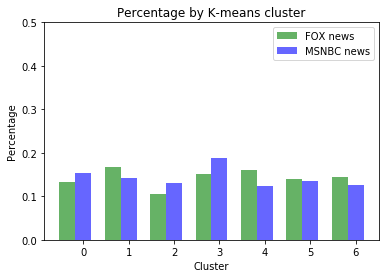

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# create plot
fig, ax = plt.subplots()
index = np.asarray(list(fox_dist.keys()))
bar_width = 0.35
opacity = 0.6


rects1 = plt.bar(index, np.asarray(list(fox_dist.values())), 
                 bar_width, alpha=opacity, color='g', label='FOX news')
rects2 = plt.bar(index + bar_width, np.asarray(list(msnbc_dist.values())), 
                 bar_width, alpha=opacity, color='b', label='MSNBC news')

plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage by K-means cluster')
plt.xticks(index + bar_width, set(list(fox_dist.keys())))
plt.ylim(top=0.5)
plt.legend()


# plt.tight_layout()
plt.savefig("k=5.png")

In [119]:
# from itertools import permutations 
# perm = permutations([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 3) 
type(df.topic[0])

numpy.int64

[0.1042471  0.18918919 0.11583012 0.14285714 0.17374517 0.14671815
 0.12741313]
[0.15853659 0.08536585 0.18292683 0.14634146 0.08536585 0.14634146
 0.19512195]
[0.1042471  0.29343629 0.40926641 0.55212355 0.72586873 0.87258687
 1.        ]
[0.15853659 0.24390244 0.42682927 0.57317073 0.65853659 0.80487805
 1.        ]
KstestResult(statistic=0.5, pvalue=0.03839174153626465)


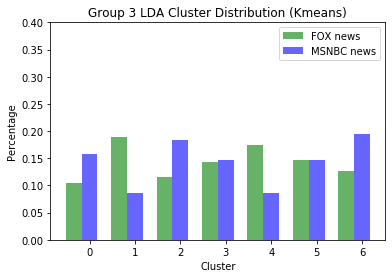

In [141]:
from scipy import stats
fig, ax = plt.subplots()

bar_width = 0.35
opacity = 0.6

g = 3

sub_df = df.loc[df.topic==g]
fox_dist = {}
msnbc_dist = {}

sum_fox = len(sub_df.loc[sub_df.source=='fox'])
sum_msnbc = len(sub_df.loc[sub_df.source=='msnbc'])

for i in set(sub_df['kmeans']):
    df_1 = sub_df.loc[sub_df['kmeans']==i]
    df_2 = sub_df.loc[sub_df['kmeans']==i]
    df_fox = df_1.loc[df_1.source=='fox']
    df_msnbc = df_2.loc[df_2.source=='msnbc']
    fox_dist[i] = len(df_fox) / sum_fox
    msnbc_dist[i] = len(df_msnbc) / sum_msnbc

index = np.asarray(list(fox_dist.keys()))
fox_dist_lis = np.array([v for k, v in fox_dist.items()])
msnbc_dist_lis = np.array([v for k, v in msnbc_dist.items()])
f = np.cumsum(fox_dist_lis)
m = np.cumsum(msnbc_dist_lis)
diff2 = np.abs(f - m)

print(fox_dist_lis)
print(msnbc_dist_lis)
print(f)
print(m)

print(stats.kstest(diff2, 'norm'))

rects1 = plt.bar(index, np.asarray(list(fox_dist.values())), 
             bar_width, alpha=opacity, color='g', label='FOX news')
rects2 = plt.bar(index + bar_width, np.asarray(list(msnbc_dist.values())), 
             bar_width, alpha=opacity, color='b', label='MSNBC news')

#     axs[g].plot(x, y)
# axs[g].set_title(f'group{g}')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title(f'Group {g} LDA Cluster Distribution (Kmeans)')
plt.xticks(index + bar_width, set(list(fox_dist.keys())))
plt.ylim(top=0.4)
plt.legend()


# plt.tight_layout()
plt.savefig(f"LDA_{g}.png")